In [1]:
cd models/research/object_detection

/home/scar3crow/Dropbox/WorkStation-Subrata/python/models/research/object_detection


In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from utils import *

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json


In [4]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/8-6-new-scan'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
inv_new_image = ['/home/scar3crow/Downloads/8-6-new-scan/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

print('Number of images = ', len(inv_new_image))
inv_new_image[20]

Number of images =  36


'/home/scar3crow/Downloads/8-6-new-scan/121a.jpg'

In [5]:
# Check sizes of exiting images :

# Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
    
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.head()


,image_serial,rows,columns
0,/home/scar3crow/Downloads/8-6-new-scan/101a.jpg,160,416
1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,406,870
2,/home/scar3crow/Downloads/8-6-new-scan/103a.jpg,260,416
3,/home/scar3crow/Downloads/8-6-new-scan/104a.jpg,405,911
4,/home/scar3crow/Downloads/8-6-new-scan/105a.jpg,147,416


In [190]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.read_csv('/home/scar3crow/Downloads/via_new_data.csv')
num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of classes = ', num_obj)
print('Number of unique images = ', num_images)
r_new_data[55:65]

Number of classes =  5
Number of unique images =  36


,#filename,region_shape_attributes,region_attributes
55,63a.jpg,"{""name"":""rect"",""x"":1,""y"":2,""width"":140,""height...","{""text"":""vendor""}"
56,63a.jpg,"{""name"":""rect"",""x"":210,""y"":1,""width"":70,""heigh...","{""text"":""invoice""}"
57,63a.jpg,"{""name"":""rect"",""x"":314,""y"":1,""width"":63,""heigh...","{""text"":""date""}"
58,63a.jpg,"{""name"":""rect"",""x"":211,""y"":64,""width"":76,""heig...","{""text"":""po""}"
59,63a.jpg,"{""name"":""rect"",""x"":2,""y"":68,""width"":165,""heigh...","{""text"":""buyer""}"
60,101a.jpg,"{""name"":""rect"",""x"":6,""y"":23,""width"":119,""heigh...","{""text"":""vendor""}"
61,101a.jpg,"{""name"":""rect"",""x"":254,""y"":23,""width"":40,""heig...","{""text"":""invoice""}"
62,101a.jpg,"{""name"":""rect"",""x"":331,""y"":21,""width"":52,""heig...","{""text"":""date""}"
63,101a.jpg,"{""name"":""rect"",""x"":251,""y"":70,""width"":71,""heig...","{""text"":""po""}"
64,101a.jpg,"{""name"":""rect"",""x"":6,""y"":66,""width"":142,""heigh...","{""text"":""buyer""}"


In [191]:
# Making a dataframe for Image_id, x, y, width, height and class

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []


for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]
    img_path = '/home/scar3crow/Downloads/8-6-new-scan/' + foto_id
    foto_index = df_new.index[df_new['image_serial'] == img_path]
    foto_width = df_new['columns'][foto_index].tolist()
    foto_height = df_new['rows'][foto_index].tolist()
    i_width.append(foto_width[0])
    i_height.append(foto_height[0])
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)

r_new_data.insert(loc=1, column='x', value=x_values)
r_new_data.insert(loc=2, column='y', value=y_values)
r_new_data.insert(loc=3, column='width', value=width_values)
r_new_data.insert(loc=4, column='height', value=height_values)
r_new_data.insert(loc=5, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='image_width', value=i_width_values)
r_new_data.insert(loc=9, column='image_height', value=i_height_values)


r_new_data.drop(r_new_data.columns[[6, 7]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data.head()

,img_id,x,y,width,height,obj_class,image_width,image_height
0,50a.jpg,5,1,190,57,vendor,416,209
1,50a.jpg,223,4,54,20,invoice,416,209
2,50a.jpg,323,4,56,23,date,416,209
3,50a.jpg,221,59,103,24,po,416,209
4,50a.jpg,5,57,206,56,buyer,416,209


In [192]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images

print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts()) 


Number of unique images =  36
Number of classes in diff. categories =  buyer      38
invoice    36
date       36
vendor     36
po         33
order       1
Name: obj_class, dtype: int64


In [193]:
# To find smallest width & height boxes in 'buyer' which should be 'po'
gb = r_new_data.groupby('obj_class')    
[gb.get_group('buyer') for x in gb.groups]


[       img_id    x    y  width  height obj_class  image_width  image_height
 4     50a.jpg    5   57    206      56     buyer          416           209
 9     51a.jpg    4   53    152      64     buyer          416           194
 14    52a.jpg    1   50    161      74     buyer          416           188
 19    53a.jpg    0   50    177      76     buyer          416           194
 24    54a.jpg   31  103    186      61     buyer          416           168
 29    55a.jpg    1   56    183      74     buyer          416           144
 34    56a.jpg    1   56    166      62     buyer          416           123
 39    59a.jpg    3   58    175      62     buyer          416           200
 44    60a.jpg    0   44    165      52     buyer          416           106
 49    61a.jpg    1   56    155      63     buyer          416           121
 54    62a.jpg    4   58    163      61     buyer          416           123
 59    63a.jpg    2   68    165      55     buyer          416           191

In [194]:
# Correcting above wrong spelling of object classes and rechecking

id_1 = r_new_data.index[r_new_data['obj_class'] == 'order'] # Finding the index
id_2 = r_new_data.index[r_new_data['obj_class'] == 'date'] # to change 'date' to 'inv_date' to be consistent with old data

r_new_data.at[id_1, 'obj_class'] = 'po' # writing the correct spelling 
r_new_data.at[88, 'obj_class'] = 'po' # # 'buyer' to 'po'
r_new_data.at[163, 'obj_class'] = 'po' # # 'buyer' to 'po'
r_new_data.at[id_2, 'obj_class'] = 'inv_date' # # 'date' to 'inv_date'

print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of unique classes = ', r_new_data['obj_class'].nunique())
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts()) 


Number of unique images =  36
Number of unique classes =  5
Number of classes in diff. categories =  po          36
invoice     36
inv_date    36
vendor      36
buyer       36
Name: obj_class, dtype: int64


In [11]:
## Creating train images by cropping original images as per x, y, width, height of bbox created in VGG I.A. tool

my_class_image = [] # List of class images with proper id
kount = 0

for i in range(len(inv_new_image)):
    
    id = inv_new_image[i].split('/')[-1] # finding the image_id
    indices = r_new_data.index[r_new_data['img_id'] == id].tolist() # making the list of indices of r_data where same image_id exists
    
    if len(indices) != 0:
        
        image = cv2.imread(inv_new_image[i]) ## Loading image
    
        kount = kount + 1
        
        # Cropping, making a training image list and saving training images in 'train_invoice' folder
    
        for j in indices:
        
            image_new_crop = image[r_new_data['y'][j]:r_new_data['y'][j]+r_new_data['height'][j], r_new_data['x'][j]:r_new_data['x'][j]+r_new_data['width'][j]]
        
            class_sl_id = '/home/scar3crow/Downloads/train_invoice/train_val_data/' + id.split('.')[0] + '-' + str(r_new_data['obj_class'][j]) + str(kount) + '.jpg'
        
            my_class_image.append(class_sl_id)
            
            cv2.imwrite(class_sl_id, image_new_crop)

In [12]:
# Read images for classification

image_directory = '/home/scar3crow/Downloads/train_invoice/train_val_data'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
inv_crop_image = ['/home/scar3crow/Downloads/train_invoice/train_val_data/{}'.format(i) for i in os.listdir(image_directory)] # making the list
inv_crop_image.sort() # Sorting the list

print('Number of images = ', len(inv_crop_image))
inv_crop_image[50]

Number of images =  330


'/home/scar3crow/Downloads/train_invoice/train_val_data/109a-buyer9.jpg'

In [13]:
# Check sizes of exiting images :

# Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_1 = pd.DataFrame()

for i in range(len(inv_crop_image)):
    image = cv2.imread(inv_crop_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_crop_image[i])
    
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_1.insert(loc=0, column='image_serial', value=image_num)
df_1.insert(loc=1, column='rows', value=row_values)
df_1.insert(loc=2, column='columns', value=col_values)

df_1.head()


,image_serial,rows,columns
0,/home/scar3crow/Downloads/train_invoice/train_...,86,248
1,/home/scar3crow/Downloads/train_invoice/train_...,14,126
2,/home/scar3crow/Downloads/train_invoice/train_...,16,134
3,/home/scar3crow/Downloads/train_invoice/train_...,18,136
4,/home/scar3crow/Downloads/train_invoice/train_...,60,342


In [14]:
# Finding maximum sizes :

i = df_1[['rows']].idxmax()
j = df_1[['columns']].idxmax()

print(i)
print(j)

print(df_1.loc[i])
print(df_1.loc[j])

rows    15
dtype: int64
columns    19
dtype: int64
                                         image_serial  rows  columns
15  /home/scar3crow/Downloads/train_invoice/train_...   164      307
                                         image_serial  rows  columns
19  /home/scar3crow/Downloads/train_invoice/train_...    94      601


In [335]:
categories = ['vendor', 'invoice', 'inv_date', 'po', 'buyer']

values = np.array(categories)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
cat_encoded = onehot_encoder.fit_transform(integer_encoded)

print(categories)                               
print(cat_encoded)


['vendor', 'invoice', 'inv_date', 'po', 'buyer']
[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [11]:
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

In [12]:
# Preparing Input(X) and Target(Y) file for training :

# Variable Definition

img_w = 212 # target sizes of image during classification
img_h = 212 # target sizes of image during classification

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later


for i in range(len(inv_crop_image)):
    
    image_path = inv_crop_image[i]
    
    x = Image.open(image_path)
    
#    x = cv2.imread(image_path)
    x_ratio = img_w / x.size[0]
    y_ratio = img_h / x.size[1]
    
    img = letterbox_image(x, [img_w, img_h])
    
    open_cv_image = np.array(img) 

    open_cv_image = open_cv_image[:, :, ::-1].copy() # Convert RGB to BGR
    
    
#    img = cv2.resize(x,(img_w, img_h))
    
    X_final.append(open_cv_image)
    
    Y = np.zeros((5))
    
    y_1 = inv_crop_image[i].split('/')
    y_2 = y_1[-1].split('-')[-1].split('.')
    y_3 = ''.join(i for i in y_2[0] if not i.isdigit())
    
    Y =  y_encoded[categories.index(y_3), :]
                    
    Y_final.append(Y)
    
X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
np.save('/home/scar3crow/Downloads/Data1/X_2.npy',X)
np.save('/home/scar3crow/Downloads/Data1/Y_2.npy',Y)


In [13]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('/home/scar3crow/Downloads/Data1/X_2.npy')
Y = np.load('/home/scar3crow/Downloads/Data1/Y_2.npy')

X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.8 , shuffle = True)
X = []
Y = []
X_train.shape

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(264, 212, 212, 3)

In [16]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = InceptionResNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    last_3 = Flatten()(last_layer)
    last_2 = Dense(640, activation = 'relu')(last_3)
    last_1 = Dense(320, activation = 'relu')(last_2)
    last_0 = Dense(5, activation = 'softmax')(last_1)
        
    model = Model(inp,last_0)
    
    return model


In [15]:
input_size = (img_h,img_w,3)

my_invoice_class_model= my_model(input_size)

print(my_invoice_class_model.summary())




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 212, 212, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 105, 105, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 105, 105, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 105, 105, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

In [16]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
my_invoice_class_model.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_class_model.fit(X_train, Y_train, epochs= 20, batch_size = 4, validation_data=(X_val,Y_val))


Train on 264 samples, validate on 66 samples
Epoch 1/20
264/264 [==============================] - 327s 1s/step - loss: 1.4697 - accuracy: 0.4394 - val_loss: 2.4493 - val_accuracy: 0.2424
Epoch 2/20
264/264 [==============================] - 266s 1s/step - loss: 0.4712 - accuracy: 0.8295 - val_loss: 1.1474 - val_accuracy: 0.5152
Epoch 3/20
264/264 [==============================] - 269s 1s/step - loss: 0.2681 - accuracy: 0.9242 - val_loss: 1.2254 - val_accuracy: 0.6667
Epoch 4/20
264/264 [==============================] - 266s 1s/step - loss: 0.2084 - accuracy: 0.9091 - val_loss: 0.5308 - val_accuracy: 0.7879
Epoch 5/20
264/264 [==============================] - 265s 1s/step - loss: 0.1459 - accuracy: 0.9318 - val_loss: 0.7458 - val_accuracy: 0.7879
Epoch 6/20
264/264 [==============================] - 263s 996ms/step - loss: 0.0962 - accuracy: 0.9735 - val_loss: 1.2785 - val_accuracy: 0.7727
Epoch 7/20
264/264 [==============================] - 263s 998ms/step - loss: 0.0585 - accura

In [17]:
my_invoice_class_model.fit(X_train, Y_train, epochs= 5, batch_size = 4, validation_data=(X_val,Y_val))

Train on 264 samples, validate on 66 samples
Epoch 1/5
264/264 [==============================] - 265s 1s/step - loss: 0.5258 - accuracy: 0.9015 - val_loss: 11.9494 - val_accuracy: 0.7576
Epoch 2/5
264/264 [==============================] - 269s 1s/step - loss: 0.6534 - accuracy: 0.8826 - val_loss: 2.1340 - val_accuracy: 0.7727
Epoch 3/5
264/264 [==============================] - 269s 1s/step - loss: 0.1020 - accuracy: 0.9659 - val_loss: 1.3105 - val_accuracy: 0.7879
Epoch 4/5
264/264 [==============================] - 269s 1s/step - loss: 0.1285 - accuracy: 0.9697 - val_loss: 0.4776 - val_accuracy: 0.8636
Epoch 5/5
264/264 [==============================] - 272s 1s/step - loss: 0.0449 - accuracy: 0.9811 - val_loss: 0.6324 - val_accuracy: 0.8182


In [18]:
my_invoice_class_model.fit(X_train, Y_train, epochs= 5, batch_size = 4, validation_data=(X_val,Y_val))

Train on 264 samples, validate on 66 samples
Epoch 1/5
264/264 [==============================] - 263s 995ms/step - loss: 0.0066 - accuracy: 0.9962 - val_loss: 0.4918 - val_accuracy: 0.8485
Epoch 2/5
264/264 [==============================] - 268s 1s/step - loss: 0.0220 - accuracy: 0.9886 - val_loss: 0.8448 - val_accuracy: 0.7879
Epoch 3/5
264/264 [==============================] - 274s 1s/step - loss: 0.0185 - accuracy: 0.9924 - val_loss: 2.0505 - val_accuracy: 0.7273
Epoch 4/5
264/264 [==============================] - 272s 1s/step - loss: 0.0199 - accuracy: 0.9962 - val_loss: 0.6517 - val_accuracy: 0.8333
Epoch 5/5
264/264 [==============================] - 271s 1s/step - loss: 0.0199 - accuracy: 0.9962 - val_loss: 0.5882 - val_accuracy: 0.8788


In [19]:
my_invoice_class_model.fit(X_train, Y_train, epochs= 5, batch_size = 4, validation_data=(X_val,Y_val))

Train on 264 samples, validate on 66 samples
Epoch 1/5
264/264 [==============================] - 273s 1s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5566 - val_accuracy: 0.8636
Epoch 2/5
264/264 [==============================] - 271s 1s/step - loss: 2.9382e-04 - accuracy: 1.0000 - val_loss: 0.5460 - val_accuracy: 0.8636
Epoch 3/5
264/264 [==============================] - 272s 1s/step - loss: 6.5210e-04 - accuracy: 1.0000 - val_loss: 0.6112 - val_accuracy: 0.8636
Epoch 4/5
264/264 [==============================] - 273s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6422 - val_accuracy: 0.8636
Epoch 5/5
264/264 [==============================] - 274s 1s/step - loss: 7.4152e-04 - accuracy: 1.0000 - val_loss: 0.5558 - val_accuracy: 0.8939


In [17]:
# Preparing Input(X) and Target(Y) file for training :

# Variable Definition

img_w = 208 # target sizes of image during classification
img_h = 208 # target sizes of image during classification

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later


for i in range(len(inv_crop_image)):
    
    image_path = inv_crop_image[i]
    
#    x = Image.open(image_path)
    
    x = cv2.imread(image_path)
    x_ratio = img_w / x.shape[1]
    y_ratio = img_h / x.shape[0]
    
#    img = letterbox_image(x, [img_w, img_h])
    
#    open_cv_image = np.array(img) 

#    open_cv_image = open_cv_image[:, :, ::-1].copy() # Convert RGB to BGR
    
    
    img = cv2.resize(x,(img_w, img_h))
    
    X_final.append(img)
    
    Y = np.zeros((5))
    
    y_1 = inv_crop_image[i].split('/')
    y_2 = y_1[-1].split('-')[-1].split('.')
    y_3 = ''.join(i for i in y_2[0] if not i.isdigit())
    
    Y =  y_encoded[categories.index(y_3), :]
                    
    Y_final.append(Y)
    
X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
np.save('/home/scar3crow/Downloads/Data1/X_3.npy',X)
np.save('/home/scar3crow/Downloads/Data1/Y_3.npy',Y)


In [18]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('/home/scar3crow/Downloads/Data1/X_3.npy')
Y = np.load('/home/scar3crow/Downloads/Data1/Y_3.npy')

X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.8 , shuffle = True)
X = []
Y = []
X_train.shape

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(264, 208, 208, 3)

In [52]:
input_size = (img_h,img_w,3)

my_invoice_class_model_6 = my_model(input_size)

print(my_invoice_class_model_6.summary())


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 208, 208, 3)  0                                            
__________________________________________________________________________________________________
conv2d_625 (Conv2D)             (None, 103, 103, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, 103, 103, 32) 96          conv2d_625[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 103, 103, 32) 0           batch_normalization_610[0][0]    
____________________________________________________________________________________________

In [21]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
my_invoice_class_model_6.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_class_model_6.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))


Train on 264 samples, validate on 66 samples
Epoch 1/10
264/264 [==============================] - 314s 1s/step - loss: 1.7813 - accuracy: 0.3712 - val_loss: 1.8968 - val_accuracy: 0.4091
Epoch 2/10
264/264 [==============================] - 258s 976ms/step - loss: 0.8657 - accuracy: 0.6705 - val_loss: 0.6448 - val_accuracy: 0.7121
Epoch 3/10
264/264 [==============================] - 259s 981ms/step - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4585 - val_accuracy: 0.8485
Epoch 4/10
264/264 [==============================] - 259s 981ms/step - loss: 0.2160 - accuracy: 0.9091 - val_loss: 0.4023 - val_accuracy: 0.8030
Epoch 5/10
264/264 [==============================] - 265s 1s/step - loss: 0.1578 - accuracy: 0.9356 - val_loss: 0.1730 - val_accuracy: 0.9394
Epoch 6/10
264/264 [==============================] - 267s 1s/step - loss: 0.0424 - accuracy: 0.9924 - val_loss: 0.1211 - val_accuracy: 0.9545
Epoch 7/10
264/264 [==============================] - 264s 998ms/step - loss: 0.0342 - 

In [22]:
my_invoice_class_model_6.fit(X_train, Y_train, epochs= 5, batch_size = 4, validation_data=(X_val,Y_val))

Train on 264 samples, validate on 66 samples
Epoch 1/5
264/264 [==============================] - 249s 943ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 40.6543 - val_accuracy: 0.9394
Epoch 2/5
264/264 [==============================] - 256s 970ms/step - loss: 8.4815e-04 - accuracy: 1.0000 - val_loss: 27.7456 - val_accuracy: 0.9545
Epoch 3/5
264/264 [==============================] - 259s 979ms/step - loss: 5.6997e-04 - accuracy: 1.0000 - val_loss: 48.9650 - val_accuracy: 0.9545
Epoch 4/5
264/264 [==============================] - 257s 975ms/step - loss: 7.0529e-04 - accuracy: 1.0000 - val_loss: 23.2602 - val_accuracy: 0.9697
Epoch 5/5
264/264 [==============================] - 252s 954ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 46.4521 - val_accuracy: 0.9545


In [25]:
# Read images for classification

image_test_directory = '/home/scar3crow/Downloads/train_invoice/test_data'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
inv_crop_test_image = ['/home/scar3crow/Downloads/train_invoice/test_data/{}'.format(i) for i in os.listdir(image_test_directory)] # making the list
inv_crop_test_image.sort() # Sorting the list

print('Number of test images = ', len(inv_crop_test_image))

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later


for i in range(len(inv_crop_test_image)):
    
    test_image_path = inv_crop_test_image[i]
    
#    x = Image.open(image_path)
    
    x = cv2.imread(test_image_path)
    x_ratio = img_w / x.shape[1]
    y_ratio = img_h / x.shape[0]
    
#    img = letterbox_image(x, [img_w, img_h])
    
#    open_cv_image = np.array(img) 

#    open_cv_image = open_cv_image[:, :, ::-1].copy() # Convert RGB to BGR
    
    
    img = cv2.resize(x,(img_w, img_h))
    
    X_final.append(img)
    
#    Y = np.zeros((5))
    
#    y_1 = inv_crop_image[i].split('/')
#    y_2 = y_1[-1].split('-')[-1].split('.')
#    y_3 = ''.join(i for i in y_2[0] if not i.isdigit())
    
#    Y =  y_encoded[categories.index(y_3), :]
                    
#    Y_final.append(Y)
    
X_test = np.array(X_final)
X_final = []
# Y = np.array(Y_final)
# Y_final = []

X_test = (X_test - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
# np.save('/home/scar3crow/Downloads/Data1/X_3.npy',X)
# np.save('/home/scar3crow/Downloads/Data1/Y_3.npy',Y)
X_test.shape

Number of test images =  5


(5, 208, 208, 3)

In [26]:
preds = my_invoice_class_model_6.predict(X_test)
print(preds.shape)

(5, 5)


In [28]:
for i in range(preds.shape[0]):
    print(inv_crop_test_image[i])
    print(np.argmax(preds[i,:]))
    print('===================')

/home/scar3crow/Downloads/train_invoice/test_data/124a-buyer24.jpg
0
/home/scar3crow/Downloads/train_invoice/test_data/124a-date24.jpg
1
/home/scar3crow/Downloads/train_invoice/test_data/124a-invoice24.jpg
2
/home/scar3crow/Downloads/train_invoice/test_data/124a-po24.jpg
3
/home/scar3crow/Downloads/train_invoice/test_data/124a-vendor24.jpg
4


In [40]:
input_size

(208, 208, 3)

In [67]:
model_y_3 = my_invoice_class_model_6
model_y_3.layers.pop()
model_y_1.layers.pop()
model_y_1.layers.pop()
model_y_1.layers.pop()

model_y_3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 208, 208, 3)  0                                            
__________________________________________________________________________________________________
conv2d_625 (Conv2D)             (None, 103, 103, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, 103, 103, 32) 96          conv2d_625[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 103, 103, 32) 0           batch_normalization_610[0][0]    
____________________________________________________________________________________________

In [390]:
last_2 = Conv2D(768,(5,5) , activation='relu' , padding='same')(model_y_3.layers[-1].output)
    
last_1  = Conv2D(384,(3,3) , activation='relu' , padding='same')(last_2)
    
last_0 = Conv2D(1690,(3,3) , activation='relu' , padding='valid')(last_1)

# last = Conv2D(5070,(3,3) , activation='relu', padding='valid')(last_0)

last = Conv2D(5070,(3,3), padding='valid')(last_0)
    
final = Reshape((13, 13, 3, 10))(last)
        
model_yolo_1 = Model(model_y_3.input, final)
    

model_yolo_1.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 208, 208, 3)  0                                            
__________________________________________________________________________________________________
conv2d_625 (Conv2D)             (None, 103, 103, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, 103, 103, 32) 96          conv2d_625[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 103, 103, 32) 0           batch_normalization_610[0][0]    
___________________________________________________________________________________________

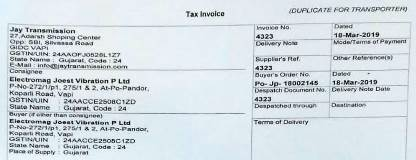

In [79]:
image = cv2.imread(inv_new_image[0])
image_pil = Image.fromarray(image)
display(image_pil)

In [87]:
inv_new_image[0]

'/home/scar3crow/Downloads/8-6-new-scan/101a.jpg'

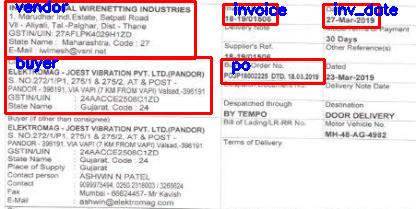

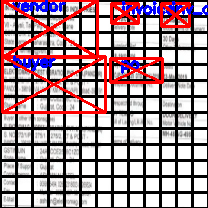

In [272]:
image_list = r_new_data['img_id'].unique() # make a list of unique images
# image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + image_list[0]
image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + '50a.jpg'

x = cv2.imread(image_path)
x_ratio = img_w / x.shape[1]
y_ratio = img_h / x.shape[0]
xx = cv2.resize(x,(img_w, img_h))

r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[0]])].reset_index(drop=True) # slicing as per current image id

m = int(208/13)
n = int(208/13)

x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]
y_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]

for i in x_range:
        for j in y_range:
            cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)



for j in range(len(r_new_data_slice)):
        
    xmin = r_new_data_slice['x'][j]
    ymin = r_new_data_slice['y'][j]
    
    xxmin = int(r_new_data_slice['x'][j]*x_ratio)
    yymin = int(r_new_data_slice['y'][j]*y_ratio)
 
    xmax = (r_new_data_slice['x'][j] + r_new_data_slice['width'][j])
    ymax = (r_new_data_slice['y'][j] + r_new_data_slice['height'][j])
    
    xxmax = int((r_new_data_slice['x'][j] + r_new_data_slice['width'][j])*x_ratio)
    yymax = int((r_new_data_slice['y'][j] + r_new_data_slice['height'][j])*y_ratio)
        
    obj_class = r_new_data_slice['obj_class'][j]
        
    cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
    cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
x_pil = Image.fromarray(x)
display(x_pil)

xx_pil = Image.fromarray(xx)
display(xx_pil)

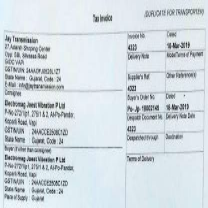

In [81]:
ige = cv2.resize(image,(img_w, img_h))
ige_pil = Image.fromarray(ige)
display(ige_pil)

In [ ]:
# Preparing Input(X) and Target(Y) file for training :

# Variable Definition

channels = 3
anchors = 1
classes = 5 # vendor, buyer, invoice, inv_date, po, item_detail, totals
info = 5 + classes    # pc, x, y, h, w, and class probabilities

grid_y_axis = 13  # each image is to be segmented to 16 x 16 grid
grid_x_axis = 13  # # each image is to be segmented to 16 x 16 grid

target_w = 208 # target sizes as per MobileNetV2
target_h = 208 #target sizes as per MobileNetV2

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later

image_list = r_new_data['img_id'].unique() # make a list of unique images

for i in image_list:
    
    image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + i
    
    x = cv2.imread(image_path)
    x_ratio = target_w / x.shape[1]
    y_ratio = target_h / x.shape[0]
    img = cv2.resize(x,(target_w, target_h))
    
    X_final.append(img)
    
    Y = np.zeros((grid_y_axis,grid_x_axis,anchors,info))
    
    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([i])].reset_index(drop=True) # slicing as per current image id
    
    for j in range(len(r_new_data_slice)):
        
        xmin = r_new_data_slice['x'][j] * x_ratio
        ymin = r_new_data_slice['y'][j] * y_ratio
        
        xmax = (r_new_data_slice['x'][j] + r_new_data_slice['box_width'][j]) * x_ratio
        ymax = (r_new_data_slice['y'][j] + r_new_data_slice['box_height'][j]) * y_ratio
        
        obj_class = r_data_slice['obj_class'][j]
        
        w = (xmax - xmin)/(img_w/grid_x_axis)
        h = (ymax - ymin)/(img_h/grid_y_axis)

#        x = (xmin + (xmax-xmin)/2)/img_
#        y = (ymin + (ymax-ymin)/2)/img_h
        
#        x = x * grid_y_axis
#        y = y * grid_x_axis

        x = xmin + (xmax - xmin) / 2  ## Center of the box from left of resized image
        y = ymin + (ymax - ymin) / 2  ## Center of the box from top of resized image
        
        x = x - target_w/grid_x_axis
        y = y - yarget_h / grid_x_axis
        
        Y[int(y),int(x),0] = 1
        Y[int(y),int(x),1] = x - int(x)
        Y[int(y),int(x),2] = y - int(y)
        Y[int(y),int(x),3] = w
        Y[int(y),int(x),4] = h
        
        balance_Y = y_encoded[categories.tolist().index(obj_class), :]
        
        Y[int(y),int(x),5] = balance_Y[0]
        Y[int(y),int(x),6] = balance_Y[1]
        Y[int(y),int(x),7] = balance_Y[2]
        Y[int(y),int(x),8] = balance_Y[3]
        Y[int(y),int(x),9] = balance_Y[4]
        
        print(i, int(y), int(x))
        print(Y[int(y),int(x)])
        
    
        
    Y_final.append(Y)
    print('==================================================')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(Y_final)
X = np.array(X_final) 
#X_final = []
Y = np.array(Y_final)
#Y_final = []

X = (X - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
# np.save('/home/scar3crow/Downloads/Data1/X_short.npy',X)
# np.save('/home/scar3crow/Downloads/Data1/Y_short.npy',Y)


In [112]:
## iou based on xmin, ymin, xmax, ymax

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou


In [125]:
def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]


    while True:
        for row in range(rows):
            distances[row] = 1 - iou_kmeans(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [313]:
r_new_data.head()

,img_id,x,y,width,height,obj_class,image_width,image_height
0,50a.jpg,5,1,190,57,vendor,416,209
1,50a.jpg,223,4,54,20,invoice,416,209
2,50a.jpg,323,4,56,23,inv_date,416,209
3,50a.jpg,221,59,103,24,po,416,209
4,50a.jpg,5,57,206,56,buyer,416,209


In [136]:
len(r_new_data)

180

In [336]:
target_w = 208 # target sizes as per MobileNetV2
target_h = 208 #target sizes as per MobileNetV2

grid_y_axis = 13  # each image is to be segmented to 16 x 16 grid
grid_x_axis = 13  # # each image is to be segmented to 16 x 16 grid

grid_w = target_w / grid_x_axis
grid_h = target_h / grid_y_axis

channels = 3
num_anchors = 3
classes = 5 # vendor, buyer, invoice, inv_date, po, item_detail, totals
info = 5 + classes    # pc, x, y, h, w, and class probabilities



In [320]:
grid_y_axis = 13  # each image is to be segmented to 16 x 16 grid
grid_x_axis = 13  # # each image is to be segmented to 16 x 16 grid

b_box_wrt_cell = np.zeros((len(r_new_data),2))
for i in range(len(r_new_data)):
    
    x_ratio = target_w / image_w
    y_ratio = target_h / image_h
    
    anchor_w = r_new_data['width'][i] * x_ratio / (target_w/grid_x_axis)
    anchor_h = r_new_data['height'][i] * y_ratio / (target_h/grid_y_axis)
    
    b_box_wrt_cell[i, 0] = anchor_w
    b_box_wrt_cell[i, 1] = anchor_h


In [318]:
b_box_wrt_cell = np.zeros((5,2))
for i in range(5):
    
    x_ratio = target_w / image_w
    
    y_ratio = target_h / image_h

    
    anchor_w = r_new_data['width'][i] * x_ratio / (target_w/grid_x_axis)
    anchor_h = r_new_data['height'][i] * y_ratio / (target_h/grid_y_axis)
    b_box_wrt_cell[i, 0] = anchor_w
    b_box_wrt_cell[i, 1] = anchor_h


In [319]:
b_box_wrt_cell

array([[5.9375    , 3.54545455],
       [1.6875    , 1.24401914],
       [1.75      , 1.43062201],
       [3.21875   , 1.49282297],
       [6.4375    , 3.48325359]])

In [306]:
b_box = np.zeros((len(r_new_data),2))
for i in range(len(r_new_data)):
    
    image_w = r_new_data['image_width'][j]
    image_h = r_new_data['image_height'][j]
    
    x_ratio = target_w / image_w
    
    y_ratio = target_h / image_h
    
#    bb_w = (r_new_data['width'][i] * x_ratio) / target_w
#    bb_h = (r_new_data['height'][i] * y_ratio) / target_h

    bb_w = (r_new_data['width'][i] * x_ratio)
    bb_h = (r_new_data['height'][i] * y_ratio)
    
    b_box[i, 0] = bb_w
    b_box[i, 1] = bb_h



In [307]:
anchors = kmeans(b_box, 3)

print(type(anchors))
print(anchors.shape)
print(anchors)

<class 'numpy.ndarray'>
(3, 2)
[[88.5        63.6937799 ]
 [32.         20.89952153]
 [72.75       49.76076555]]


In [321]:
anchors_wrt_cell = kmeans(b_box_wrt_cell, 3)
print(type(anchors_wrt_cell))
print(anchors_wrt_cell.shape)
print(anchors_wrt_cell)

<class 'numpy.ndarray'>
(3, 2)
[[3.4375     1.05741627]
 [5.1875     3.48325359]
 [1.75       1.36842105]]


In [184]:
## iou based on width and height

def iou_kmeans(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou = intersection / (box_area + cluster_area - intersection)

    return iou


In [365]:
##  https://github.com/Tony607/YOLO_Object_Localization_Keras/blob/master/yad2k/models/keras_yolo.py

##  voc_anchors = np.array(
##    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

## voc_classes = [
##    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
##    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
##    "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.
    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.
    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
        
    """
    
    height, width = image_size
    print(height, width)
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
#    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
#    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 16
    conv_width = width // 16
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)

    for box in true_boxes:
        print('true box sizes =', box)
        # scale box to convolutional feature spatial dimensions
        box_class = box[4:5]
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        print('##################################')
        print(box)
        i = np.floor(box[1]).astype('int')
        print('++++++++++++++++++', i)
        
#        j = min(np.floor(box[0]).astype('int'),1)
        j = np.floor(box[0]).astype('int')
        print('====================', j)
        
        best_iou = 0
        best_anchor = 0
                
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k
                
        print('iou = ', best_iou, best_anchor)
        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            print('??????????????????', i, j, box_class)
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes

In [339]:
## x & y w.r.t. cell and w,h w.r.t. image

target_size = [208, 208]


## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

anchors = anchors_wrt_cell

r_new_data_slice = r_new_data.loc[r_new_data['img_id']=='50a.jpg'].reset_index(drop=True) # slicing

true_boxes = np.zeros((len(r_new_data_slice),5))

obj = 0

for j in range(len(r_new_data_slice)):
    
    image_w = r_new_data_slice['image_width'][j]
    image_h = r_new_data_slice['image_height'][j]
    
    x_ratio = target_size[1] / image_w
    
    y_ratio = target_size[0] / image_h
    

    
    xmin = r_new_data_slice['x'][j] * x_ratio
    ymin = r_new_data_slice['y'][j] * y_ratio
        
    xmax = (r_new_data_slice['x'][j] + r_new_data_slice['width'][j]) * x_ratio
    ymax = (r_new_data_slice['y'][j] + r_new_data_slice['height'][j]) * y_ratio
        
#    obj_class = r_new_data_slice['obj_class'][j]
    
    
#    obj = j+1
    
    
        
    w = (r_new_data_slice['width'][j] * x_ratio) / target_size[1]
    
    h = (r_new_data_slice['height'][j] * y_ratio) / target_size[0]
    
    
    x = (xmin + (xmax-xmin)/2) / target_size[1]
    y = (ymin + (ymax-ymin)/2) / target_size[0] 
    
#    x = (x * grid_x_axis/image_size[1]) - int(x * grid_x_axis/image_size[1])
#    y = (y * grid_y_axis/image_size[0]) - int(y * grid_y_axis/image_size[0])
    
    true_boxes[j][0] = x
    true_boxes[j][1] = y
    true_boxes[j][2] = w
    true_boxes[j][3] = h
    true_boxes[j][4] = obj
    obj = obj+1

print(true_boxes.shape)

r_new_data_slice.head()


(5, 5)


,img_id,x,y,width,height,obj_class,image_width,image_height
0,50a.jpg,5,1,190,57,vendor,416,209
1,50a.jpg,223,4,54,20,invoice,416,209
2,50a.jpg,323,4,56,23,inv_date,416,209
3,50a.jpg,221,59,103,24,po,416,209
4,50a.jpg,5,57,206,56,buyer,416,209


In [354]:
true_boxes

array([[0.24038462, 0.14114833, 0.45673077, 0.27272727, 0.        ],
       [0.60096154, 0.06698565, 0.12980769, 0.09569378, 1.        ],
       [0.84375   , 0.07416268, 0.13461538, 0.11004785, 2.        ],
       [0.65504808, 0.33971292, 0.24759615, 0.11483254, 3.        ],
       [0.25961538, 0.40669856, 0.49519231, 0.26794258, 4.        ]])

In [366]:
c, d = preprocess_true_boxes(true_boxes, anchors, target_size)

208 208
true box sizes = [0.24038462 0.14114833 0.45673077 0.27272727 0.        ]
##################################
[3.125      1.83492823 5.9375     3.54545455]
++++++++++++++++++ 1
==================== 3
iou =  0.8583564173591873 1
?????????????????? 1 3 [0.]
true box sizes = [0.60096154 0.06698565 0.12980769 0.09569378 1.        ]
##################################
[7.8125     0.8708134  1.6875     1.24401914]
++++++++++++++++++ 0
==================== 7
iou =  0.8766233766233769 2
?????????????????? 0 7 [1.]
true box sizes = [0.84375    0.07416268 0.13461538 0.11004785 2.        ]
##################################
[10.96875     0.96411483  1.75        1.43062201]
++++++++++++++++++ 0
==================== 10
iou =  0.9565217391304346 2
?????????????????? 0 10 [2.]
true box sizes = [0.65504808 0.33971292 0.24759615 0.11483254 3.        ]
##################################
[8.515625   4.41626794 3.21875    1.49282297]
++++++++++++++++++ 4
==================== 8
iou =  0.6758008490930

In [325]:
for k, anchor in enumerate(anchors):
    print(k)
    print(anchor)

0
[3.4375     1.05741627]
1
[5.1875     3.48325359]
2
[1.75       1.36842105]


In [368]:
d[0,0]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [369]:
d[1,3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.125     , 0.8349282 , 0.13503629, 0.01769958, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [370]:
c[1,3]

array([[0.],
       [1.],
       [0.]], dtype=float32)

In [371]:
d[1,4]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [372]:
d[0,7]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.8125    ,  0.87081337, -0.03636764, -0.09531018,  1.        ]],
      dtype=float32)

In [373]:
d[0,10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.96875   , 0.96411484, 0.        , 0.04445176, 2.        ]],
      dtype=float32)

In [374]:
d[5,3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.375     , 0.28708133, 0.21588838, 0.        , 4.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [361]:
##  https://github.com/Tony607/YOLO_Object_Localization_Keras/blob/master/yad2k/models/keras_yolo.py

##  voc_anchors = np.array(
##    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

## voc_classes = [
##    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
##    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
##    "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def preprocess_true_boxes_new(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.
    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.
    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
        
    """
    
    height, width = image_size
    print(height, width)
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
#    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
#    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 16
    conv_width = width // 16
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, info),
        dtype=np.float32)

    for box in true_boxes:
        print('true box sizes =', box)
        # scale box to convolutional feature spatial dimensions
        box_class = int(box[4:5])
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        print('##################################')
        print(box)
        i = np.floor(box[1]).astype('int')
        print('++++++++++++++++++', i)
        
#        j = min(np.floor(box[0]).astype('int'),1)
        j = np.floor(box[0]).astype('int')
        print('====================', j)
        
        best_iou = 0
        best_anchor = 0
                
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k
                
        print('iou = ', best_iou, best_anchor)
        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            print('??????????????????', i, j, box_class)
            adjusted_box = np.array(
                [   1,
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1])
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = np.hstack((adjusted_box, cat_encoded[box_class]))
    return detectors_mask, matching_true_boxes

In [438]:
a, b = preprocess_true_boxes_new(true_boxes, anchors, target_size)

208 208
true box sizes = [0.24038462 0.14114833 0.45673077 0.27272727 0.        ]
##################################
[3.125      1.83492823 5.9375     3.54545455]
++++++++++++++++++ 1
==================== 3
iou =  0.8583564173591873 1
?????????????????? 1 3 0
true box sizes = [0.60096154 0.06698565 0.12980769 0.09569378 1.        ]
##################################
[7.8125     0.8708134  1.6875     1.24401914]
++++++++++++++++++ 0
==================== 7
iou =  0.8766233766233769 2
?????????????????? 0 7 1
true box sizes = [0.84375    0.07416268 0.13461538 0.11004785 2.        ]
##################################
[10.96875     0.96411483  1.75        1.43062201]
++++++++++++++++++ 0
==================== 10
iou =  0.9565217391304346 2
?????????????????? 0 10 2
true box sizes = [0.65504808 0.33971292 0.24759615 0.11483254 3.        ]
##################################
[8.515625   4.41626794 3.21875    1.49282297]
++++++++++++++++++ 4
==================== 8
iou =  0.6758008490930143 0
???

In [363]:
b[1,3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.125     , 0.8349282 , 0.13503629, 0.01769958,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [364]:
b[0,7]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.8125    ,  0.87081337, -0.03636764, -0.09531018,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ]],
      dtype=float32)

In [376]:
a.shape

(13, 13, 3, 1)

In [377]:
a[1,3]

array([[0.],
       [1.],
       [0.]], dtype=float32)

In [378]:
a[0,7]

array([[0.],
       [0.],
       [1.]], dtype=float32)

In [407]:
b.shape

(13, 13, 3, 10)

In [397]:
anchors

array([[3.4375    , 1.05741627],
       [5.1875    , 3.48325359],
       [1.75      , 1.36842105]])

In [406]:
anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

print(anchors_tensor)

Tensor("Reshape_16:0", shape=(1, 1, 1, 3, 2), dtype=float32)


In [422]:
conv_dims = K.shape(b)[1:3] 
conv_dims

<tf.Tensor 'strided_slice_14:0' shape=(2,) dtype=int32>

In [424]:
conv_dims[0]

<tf.Tensor 'strided_slice_16:0' shape=() dtype=int32>

In [412]:
conv_height_index = K.arange(0, stop=conv_dims[0])
conv_height_index

<tf.Tensor 'arange_3:0' shape=(13,) dtype=int32>

In [413]:
conv_width_index = K.arange(0, stop=conv_dims[1])
conv_width_index

<tf.Tensor 'arange_4:0' shape=(3,) dtype=int32>

In [414]:
conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
conv_width_index

<tf.Tensor 'Tile:0' shape=(13, 3) dtype=int32>

In [418]:
conv_width_index = K.flatten(K.transpose(conv_width_index))
conv_width_index

<tf.Tensor 'Reshape_19:0' shape=(39,) dtype=int32>

In [419]:
conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
conv_index

ValueError: Dimension 0 in both shapes must be equal, but are 13 and 39. Shapes are [13] and [39].
	From merging shape 0 with other shapes. for 'stack_3' (op: 'Pack') with input shapes: [13], [39].

In [ ]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.
    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.
    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs


In [ ]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

In [425]:
anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
anchors_tensor

<tf.Tensor 'Reshape_20:0' shape=(1, 1, 1, 3, 2) dtype=float32>

In [450]:
zzz = np.expand_dims(b, axis = 0)

grid_shape = K.shape(zzz)[1:3] # height, width
grid_shape

<tf.Tensor 'strided_slice_24:0' shape=(2,) dtype=int32>

In [451]:
grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
grid_y

<tf.Tensor 'Tile_1:0' shape=(13, 13, 1, 1) dtype=int32>

In [452]:
grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
grid_x

<tf.Tensor 'Tile_2:0' shape=(13, 13, 1, 1) dtype=int32>

In [453]:
grid = K.concatenate([grid_x, grid_y])
grid

<tf.Tensor 'concat:0' shape=(13, 13, 1, 2) dtype=int32>

In [454]:
grid = K.cast(grid, K.dtype(zzz))
grid

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [439]:
b.shape

(13, 13, 3, 10)

In [447]:
np.shape(b.shape)

(4,)

In [440]:
K.shape(b)

<tf.Tensor 'Shape_6:0' shape=(4,) dtype=int32>

In [444]:
grid_shape = K.shape(b)[1:3] # height, width
grid_shape

<tf.Tensor 'strided_slice_23:0' shape=(2,) dtype=int32>

In [448]:
zzz = np.expand_dims(b, axis = 0)

In [449]:
zzz.shape

(1, 13, 13, 3, 10)

In [456]:
print(type(zzz))

<class 'numpy.ndarray'>


In [457]:
print(type(b))

<class 'numpy.ndarray'>


In [437]:
grid_shape = K.shape(zzz)[1:3] # height, width
grid_shape

<tf.Tensor 'strided_slice_19:0' shape=(2,) dtype=int32>

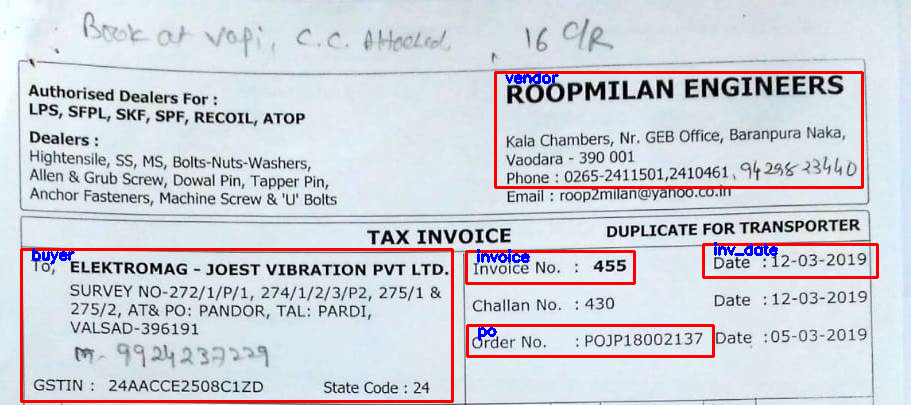

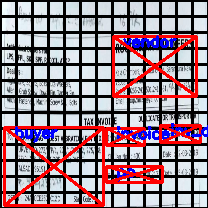

In [459]:
image_list = r_new_data['img_id'].unique() # make a list of unique images
# image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + image_list[0]
image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + '104a.jpg'

x = cv2.imread(image_path)
x_ratio = 208 / x.shape[1]
y_ratio = 208 / x.shape[0]
xx = cv2.resize(x,(img_w, img_h))

r_new_data_slice = r_new_data.loc[r_new_data['img_id'] == '104a.jpg'].reset_index(drop=True) # slicing as per current image id

m = int(208/13)
n = int(208/13)

x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]
y_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]

for i in x_range:
        for j in y_range:
            cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)



for j in range(len(r_new_data_slice)):
        
    xmin = r_new_data_slice['x'][j]
    ymin = r_new_data_slice['y'][j]
    
    xxmin = int(r_new_data_slice['x'][j]*x_ratio)
    yymin = int(r_new_data_slice['y'][j]*y_ratio)
 
    xmax = (r_new_data_slice['x'][j] + r_new_data_slice['width'][j])
    ymax = (r_new_data_slice['y'][j] + r_new_data_slice['height'][j])
    
    xxmax = int((r_new_data_slice['x'][j] + r_new_data_slice['width'][j])*x_ratio)
    yymax = int((r_new_data_slice['y'][j] + r_new_data_slice['height'][j])*y_ratio)
        
    obj_class = r_new_data_slice['obj_class'][j]
        
    cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
    cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
x_pil = Image.fromarray(x)
display(x_pil)

xx_pil = Image.fromarray(xx)
display(xx_pil)